In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
!pip install -q gdown

In [4]:
import gdown

# Define the file ID
file_id = '15-kq16ReZhTOuqzgRQC1kuZNq65Mzy-H'
# Define the destination to save the dataset
destination = 'dataset.zip'

# Download the dataset
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=15-kq16ReZhTOuqzgRQC1kuZNq65Mzy-H
From (redirected): https://drive.google.com/uc?id=15-kq16ReZhTOuqzgRQC1kuZNq65Mzy-H&confirm=t&uuid=f8243fa7-f0fd-4c30-956c-c61df73307bb
To: /content/dataset.zip
100%|██████████| 169M/169M [00:08<00:00, 20.9MB/s]


'dataset.zip'

In [5]:
# Unzip the dataset
!unzip dataset.zip -d /content/dataset

Archive:  dataset.zip
   creating: /content/dataset/Drwosiness_dataset/
   creating: /content/dataset/Drwosiness_dataset/test/
   creating: /content/dataset/Drwosiness_dataset/test/Closed/
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_107.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_115.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_116.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_120.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_129.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_130.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_132.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_137.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_14.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_148.jpg  
  inflating: /content/dataset/Drwosiness_dataset/test/Closed/_152.jpg  
  inflating: /conten

In [6]:
import os

# List the files in the dataset directory
os.listdir('/content/dataset/Drwosiness_dataset/')

['test', 'train']

In [7]:
os.listdir("/content/dataset/Drwosiness_dataset/train/")

['Open', 'no_yawn', 'Closed', 'yawn']

In [8]:
os.listdir("/content/dataset/Drwosiness_dataset/test/")

['Open', 'no_yawn', 'Closed', 'yawn']

In [9]:
# Step 1: Set up the environment
!pip install -q efficientnet_pytorch

  Preparing metadata (setup.py) ... done


In [10]:
import os

train_dir = "/content/dataset/Drwosiness_dataset/train/"

for class_name in os.listdir(train_dir):
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    image_count = len(os.listdir(class_path))
    print(f"Class: {class_name}, Image count: {image_count}")

Class: Open, Image count: 617
Class: no_yawn, Image count: 616
Class: Closed, Image count: 617
Class: yawn, Image count: 617


In [11]:
import os

test_dir = "/content/dataset/Drwosiness_dataset/test/"

for class_name in os.listdir(test_dir):
  class_path = os.path.join(test_dir, class_name)
  if os.path.isdir(class_path):
    image_count = len(os.listdir(class_path))
    print(f"Class: {class_name}, Image count: {image_count}")


Class: Open, Image count: 109
Class: no_yawn, Image count: 109
Class: Closed, Image count: 109
Class: yawn, Image count: 106


In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import random

In [40]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [42]:
# Define data transforms with data augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [44]:
# Load datasets
full_dataset = datasets.ImageFolder("/content/dataset/Drwosiness_dataset/train/", transform=train_transforms)
test_dataset = datasets.ImageFolder("/content/dataset/Drwosiness_dataset/test/", transform=test_transforms)

In [45]:
# Split the full dataset into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [46]:
# Override the transform for validation dataset
val_dataset.dataset.transform = test_transforms

In [47]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [48]:
# Define the model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [49]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [50]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [51]:
# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
num_epochs = 30
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0

In [52]:
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_drowsiness_detection_model.pth')

Epoch 1/30
Train Loss: 0.1773, Train Acc: 93.82%
Val Loss: 0.1616, Val Acc: 95.95%

Epoch 2/30
Train Loss: 0.0211, Train Acc: 99.39%
Val Loss: 0.0033, Val Acc: 99.80%

Epoch 3/30
Train Loss: 0.0244, Train Acc: 99.29%
Val Loss: 0.0054, Val Acc: 99.80%

Epoch 4/30
Train Loss: 0.0254, Train Acc: 99.19%
Val Loss: 0.1439, Val Acc: 97.77%

Epoch 5/30
Train Loss: 0.0249, Train Acc: 99.09%
Val Loss: 0.6253, Val Acc: 83.00%

Epoch 6/30
Train Loss: 0.0101, Train Acc: 99.65%
Val Loss: 0.0156, Val Acc: 99.60%

Epoch 7/30
Train Loss: 0.0304, Train Acc: 99.44%
Val Loss: 0.0225, Val Acc: 99.39%

Epoch 8/30
Train Loss: 0.0163, Train Acc: 99.49%
Val Loss: 0.0429, Val Acc: 99.19%

Epoch 9/30
Train Loss: 0.0054, Train Acc: 99.85%
Val Loss: 0.0068, Val Acc: 99.80%

Epoch 10/30
Train Loss: 0.0050, Train Acc: 99.85%
Val Loss: 0.0016, Val Acc: 100.00%

Epoch 11/30
Train Loss: 0.0021, Train Acc: 99.95%
Val Loss: 0.0016, Val Acc: 100.00%

Epoch 12/30
Train Loss: 0.0032, Train Acc: 99.85%
Val Loss: 0.0019, Val 

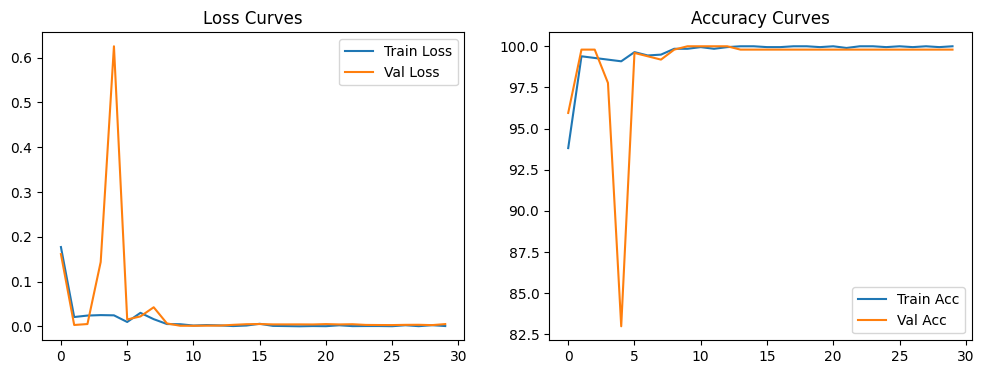

In [53]:
# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [54]:
# Load the best model for final evaluation
model.load_state_dict(torch.load('best_drowsiness_detection_model.pth'))

<ipython-input-54-20b87fef21fb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_drowsiness_detection_model.pth'))


<All keys matched successfully>

In [55]:
# Final evaluation
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.0359, Test Acc: 99.31%


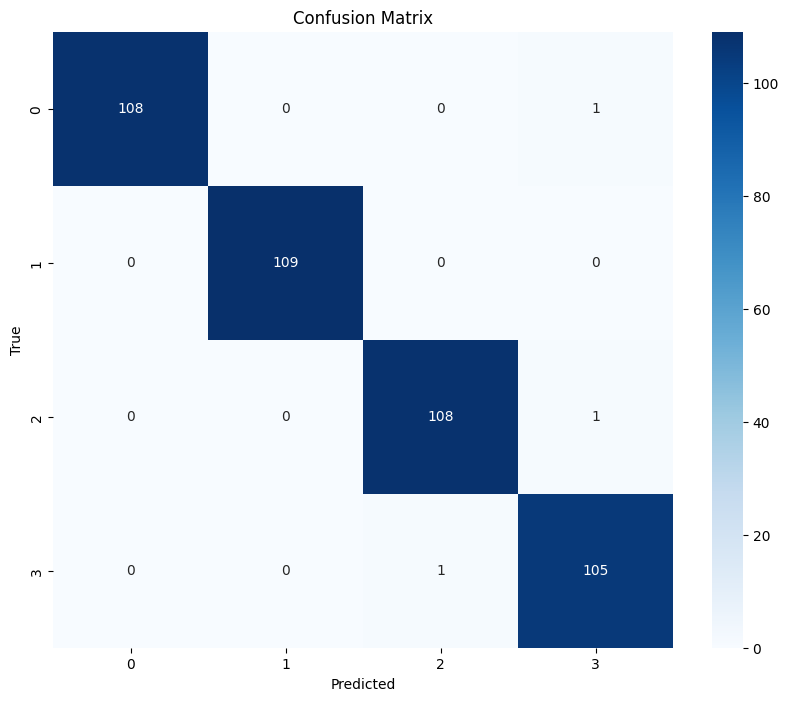

In [56]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [57]:
# Classification Report
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

              precision    recall  f1-score   support

      Closed       1.00      0.99      1.00       109
        Open       1.00      1.00      1.00       109
     no_yawn       0.99      0.99      0.99       109
        yawn       0.98      0.99      0.99       106

    accuracy                           0.99       433
   macro avg       0.99      0.99      0.99       433
weighted avg       0.99      0.99      0.99       433



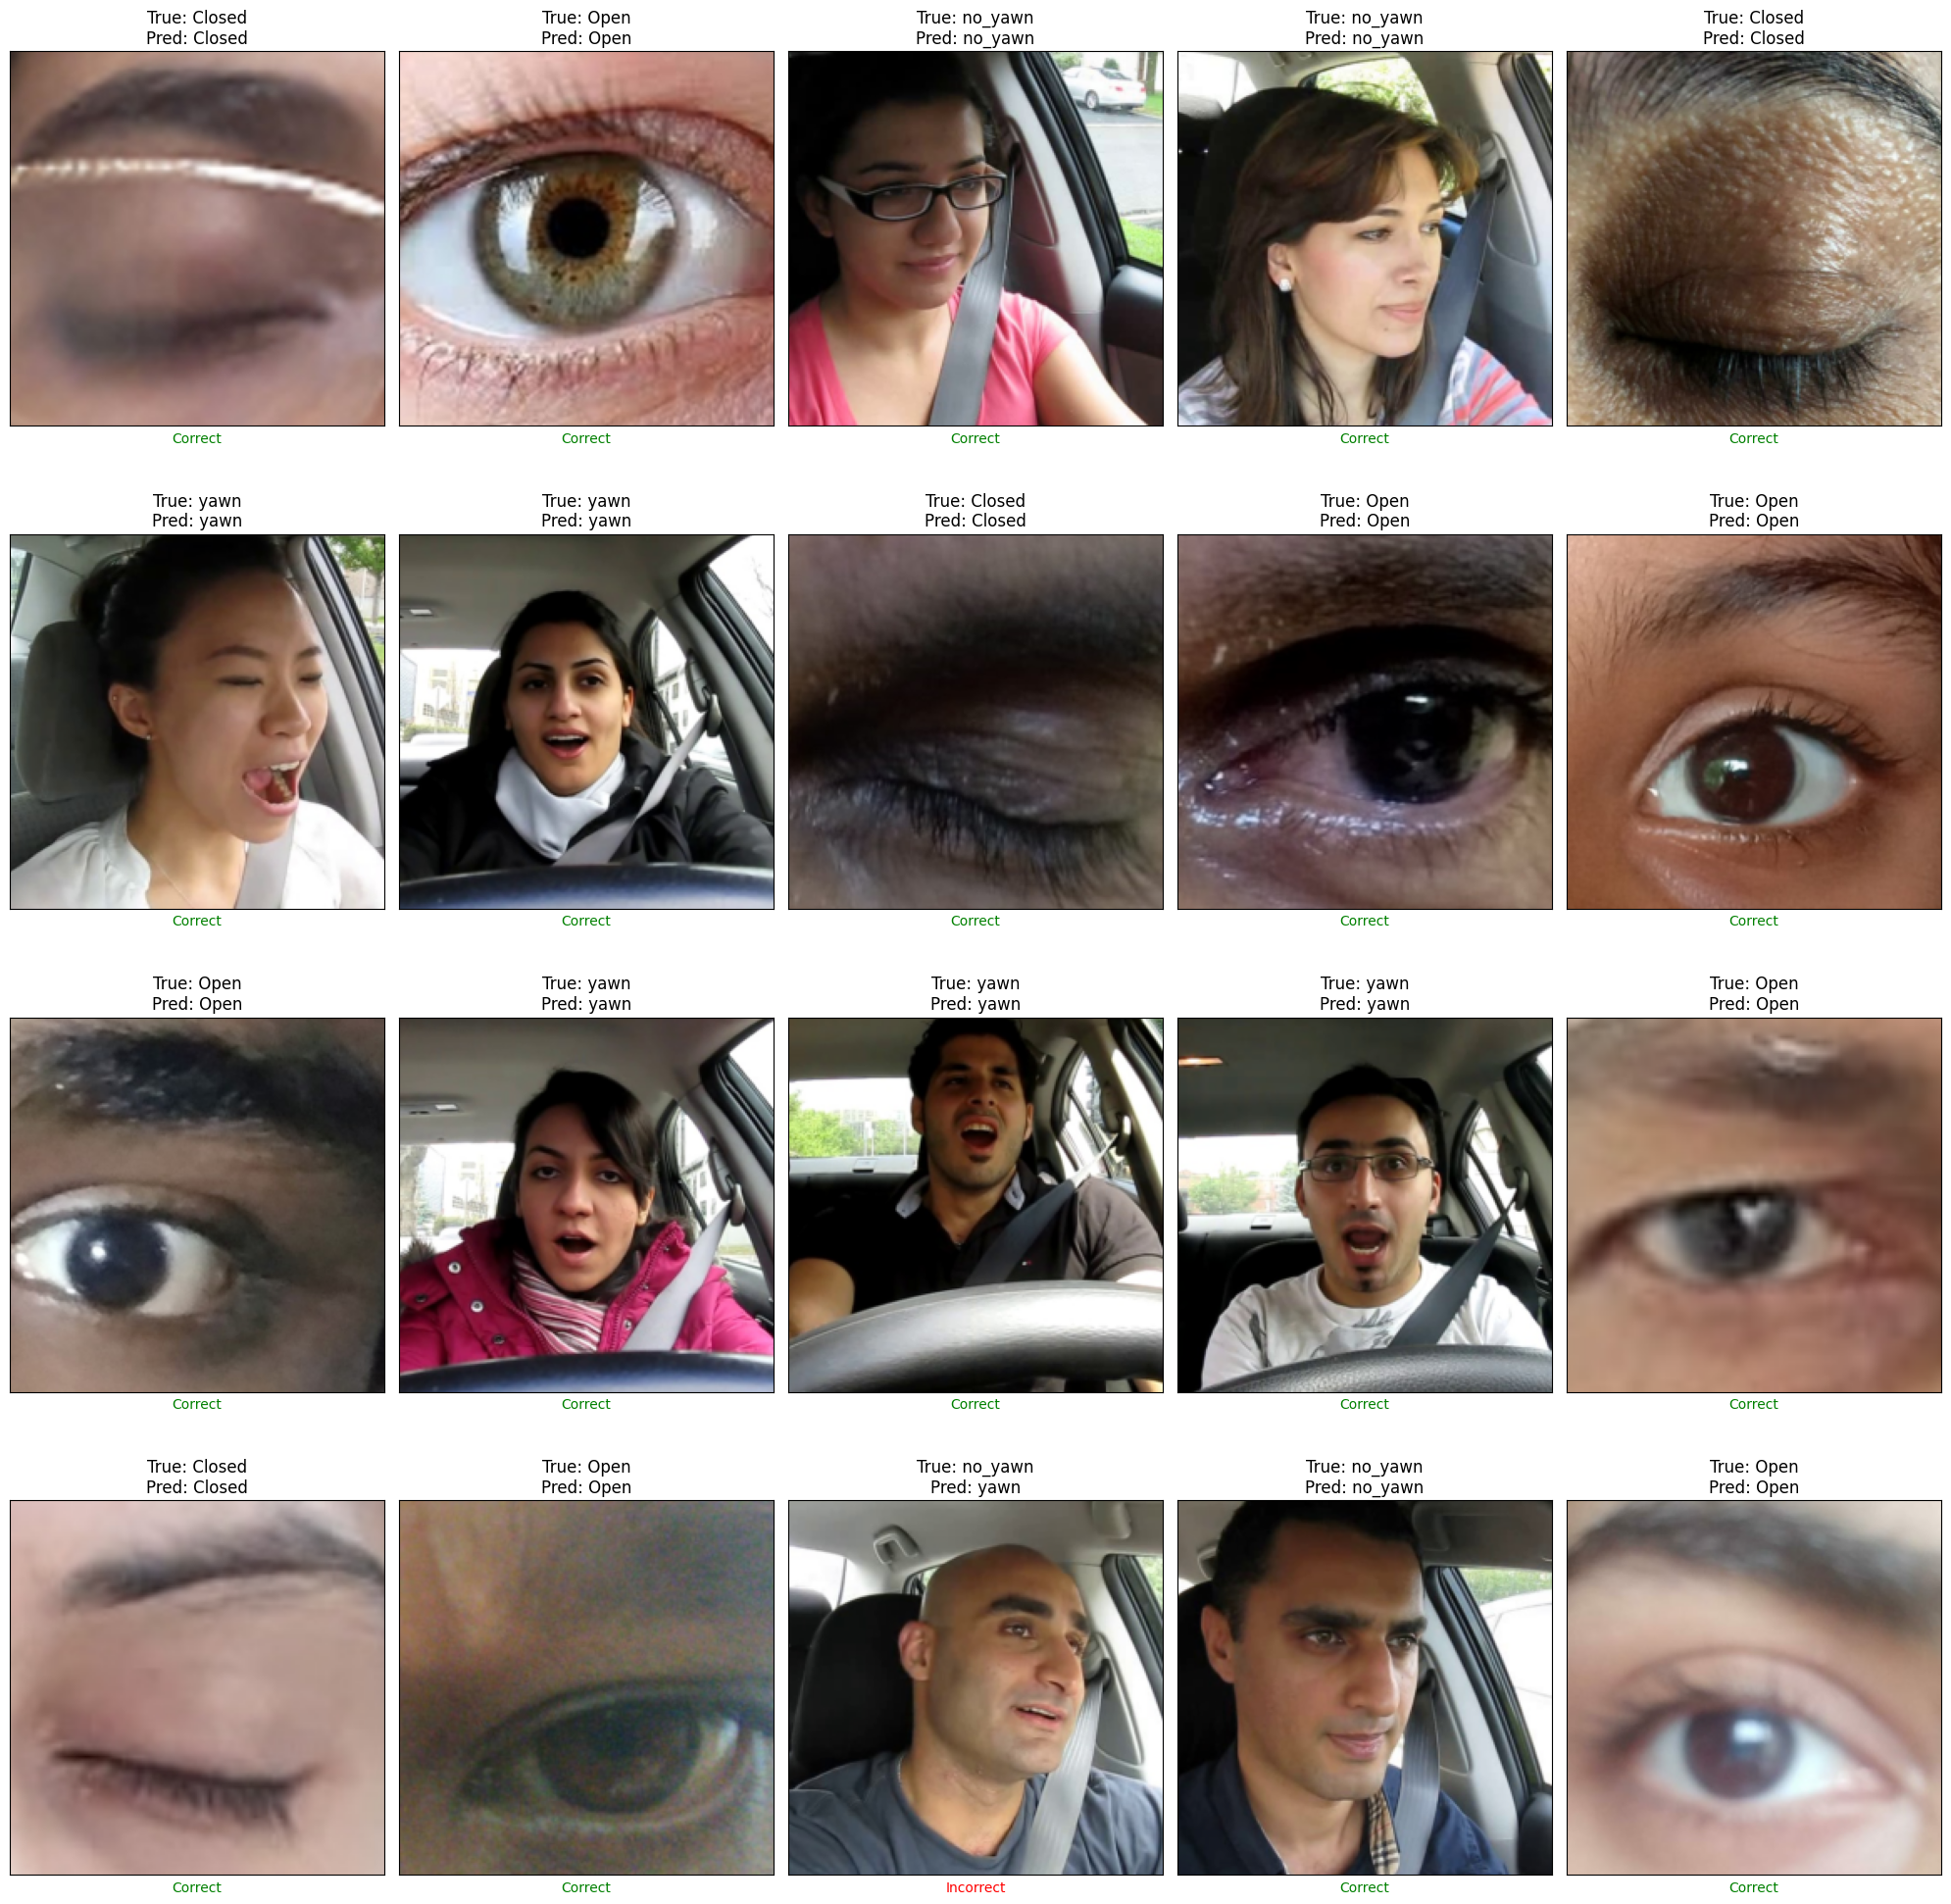

In [58]:
# Function to display random images with predictions
def display_random_images(dataset, model, device, num_images=20):
    model.eval()
    fig = plt.figure(figsize=(20, 20))
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    for i in range(num_images):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        img = images[i].cpu().permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"True: {dataset.classes[labels[i]]}\nPred: {dataset.classes[preds[i]]}")
        ax.set_xlabel("Correct" if preds[i] == labels[i] else "Incorrect", color="green" if preds[i] == labels[i] else "red")

    plt.tight_layout()
    plt.show()

# Display random images with predictions
display_random_images(test_dataset, model, device)